### This example demonstrates the use of experience replay with XCSF
Uses the cart-pole problem from the [OpenAI Gym](https://gym.openai.com).

In [1]:
from __future__ import annotations

import random
from collections import deque
from typing import Final

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from matplotlib import animation, rcParams
from tqdm import tqdm

import xcsf

### Initialise OpenAI Gym problem environment

In [2]:
env = gym.make("CartPole-v0")
X_DIM: Final[int] = env.observation_space.shape[0]
N_ACTIONS: Final[int] = env.action_space.n

### Initialise XCSF

In [3]:
# constructor = (x_dim, y_dim, n_actions)
xcs: xcsf.XCS = xcsf.XCS(X_DIM, N_ACTIONS, 1)  # Supervised: i.e, single action

xcs.OMP_NUM_THREADS = 8  # number of CPU cores to use
xcs.POP_INIT = False  # use covering to initialise
xcs.MAX_TRIALS = 1  # one trial per fit
xcs.POP_SIZE = 200  # maximum population size
xcs.E0 = 0.001  # target error
xcs.BETA = 0.05  # classifier parameter update rate
xcs.ALPHA = 1  # accuracy offset
xcs.NU = 5  # accuracy slope
xcs.EA_SUBSUMPTION = False
xcs.SET_SUBSUMPTION = False
xcs.THETA_EA = 100  # EA invocation frequency
xcs.THETA_DEL = 100  # min experience before fitness used for deletion

condition_layers: Final[dict] = {
    "layer_0": {  # hidden layer
        "type": "connected",
        "activation": "selu",
        "evolve_weights": True,
        "evolve_neurons": True,
        "n_init": 1,
        "n_max": 100,
        "max_neuron_grow": 1,
    },
    "layer_1": {  # output layer
        "type": "connected",
        "activation": "linear",
        "evolve_weights": True,
        "n_init": 1,
    },
}

xcs.condition("neural", condition_layers)  # neural network conditions
xcs.action("integer")  # (dummy) integer actions
xcs.prediction("rls_quadratic")  # Quadratic RLS

GAMMA: Final[float] = 0.95  # discount rate for delayed reward
epsilon: float = 1  # initial probability of exploring
EPSILON_MIN: Final[float] = 0.1  # the minimum exploration rate
EPSILON_DECAY: Final[float] = 0.98  # the decay of exploration after each batch replay
REPLAY_TIME: Final[int] = 1  # perform replay update every n episodes

print(xcs.json_parameters())

{
	"version":	"1.1.6",
	"x_dim":	4,
	"y_dim":	2,
	"n_actions":	1,
	"omp_num_threads":	8,
	"pop_init":	false,
	"max_trials":	1,
	"perf_trials":	1000,
	"pop_size":	200,
	"loss_func":	"mae",
	"set_subsumption":	false,
	"theta_sub":	100,
	"e0":	0.001,
	"alpha":	1,
	"nu":	5,
	"beta":	0.05,
	"delta":	0.1,
	"theta_del":	100,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	100,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	false,
		"pred_reset":	false
	},
	"condition":	{
		"type":	"neural",
		"args":	{
			"layer_0":	{
				"type":	"connected",
				"activation":	"selu",
				"n_inputs":	4,
				"n_init":	1,
				"evolve_weights":	true,
				"evolve_functions":	false,
				"evolve_connect":	false,
				"evolve_neurons":	true,
				"n_max":	100,
				"max_neuron_grow":	1,
				"sgd_weights":	false
			},
			"layer_1":	{
				"type":	"connected",
				"activ

### Execute experiment

In [4]:
total_steps: int = 0  # total number of steps performed
MAX_EPISODES: Final[int] = 2000  # maximum number of episodes to run
N: Final[int] = 100  # number of episodes to average performance
memory: deque[tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=50000)
scores: deque[float] = deque(maxlen=N)  # used to calculate moving average

# for rendering an episode as a gif
SAVE_GIF: Final[bool] = True
SAVE_GIF_EPISODES: Final[int] = 50

frames: list[list[float]] = []
fscore: list[float] = []
ftrial: list[int] = []


def replay(replay_size: int = 5000) -> None:
    """Performs experience replay updates"""
    batch_size: Final[int] = min(len(memory), replay_size)
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        y_target = reward
        if not done:
            prediction_array = xcs.predict(next_state.reshape(1, -1))[0]
            y_target += GAMMA * np.max(prediction_array)
        target = xcs.predict(state.reshape(1, -1))[0]
        target[action] = y_target
        xcs.fit(state.reshape(1, -1), target.reshape(1, -1), True)


def egreedy_action(state: np.ndarray) -> int:
    """Selects an action using an epsilon greedy policy"""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS)
    prediction_array = xcs.predict(state.reshape(1, -1))[0]
    return int(np.argmax(prediction_array))


def episode(episode_nr: int, create_gif: bool) -> tuple[float, int]:
    """Executes a single episode, saving to memory buffer"""
    episode_score: int = 0
    episode_steps: int = 0
    state: np.ndarray = env.reset()
    while True:
        action = egreedy_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_steps += 1
        episode_score += reward
        memory.append((state, action, reward, next_state, done))
        if create_gif:
            frames.append(env.render(mode="rgb_array"))
            fscore.append(episode_score)
            ftrial.append(episode_nr)
        if done:
            if create_gif:
                for _ in range(100):
                    frames.append(frames[-1])
                    fscore.append(fscore[-1])
                    ftrial.append(ftrial[-1])
            break
        state = next_state
    return episode_score, episode_steps


# learning episodes
for ep in range(MAX_EPISODES):
    gif: bool = False
    if SAVE_GIF and ep % SAVE_GIF_EPISODES == 0:
        gif = True
    # execute a single episode
    ep_score, ep_steps = episode(ep, gif)
    # perform experience replay updates
    if ep % REPLAY_TIME == 0:
        replay()
    # display performance
    total_steps += ep_steps
    scores.append(ep_score)
    mean_score = np.mean(scores)
    print(
        f"episodes={ep} "
        f"steps={total_steps} "
        f"score={mean_score:.2f} "
        f"epsilon={epsilon:.5f} "
        f"error={xcs.error():.5f} "
        f"msize={xcs.mset_size():.2f}"
    )
    # is the problem solved?
    if ep > N and mean_score > env.spec.reward_threshold:
        print(
            f"solved after {ep} episodes: "
            f"mean score {mean_score:.2f} > {env.spec.reward_threshold:.2f}"
        )
        break
    # decay the exploration rate
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY

episodes=0 steps=26 score=26.00 epsilon=1.00000 error=0.73670 msize=0.98
episodes=1 steps=66 score=33.00 epsilon=0.98000 error=1.58766 msize=1.00
episodes=2 steps=86 score=28.67 epsilon=0.96040 error=1.11812 msize=3.00
episodes=3 steps=165 score=41.25 epsilon=0.94119 error=4.40109 msize=7.00
episodes=4 steps=186 score=37.20 epsilon=0.92237 error=1.61565 msize=10.98
episodes=5 steps=202 score=33.67 epsilon=0.90392 error=2.05011 msize=14.98
episodes=6 steps=214 score=30.57 epsilon=0.88584 error=1.69896 msize=18.86
episodes=7 steps=260 score=32.50 epsilon=0.86813 error=2.04652 msize=24.43
episodes=8 steps=279 score=31.00 epsilon=0.85076 error=2.43929 msize=29.14
episodes=9 steps=321 score=32.10 epsilon=0.83375 error=2.87598 msize=36.56
episodes=10 steps=352 score=32.00 epsilon=0.81707 error=1.32315 msize=42.80
episodes=11 steps=368 score=30.67 epsilon=0.80073 error=1.58230 msize=49.33
episodes=12 steps=392 score=30.15 epsilon=0.78472 error=2.02377 msize=58.49
episodes=13 steps=403 score=2

episodes=106 steps=11572 score=113.58 epsilon=0.11748 error=0.11566 msize=196.54
episodes=107 steps=11772 score=115.12 epsilon=0.11513 error=0.10911 msize=190.89
episodes=108 steps=11972 score=116.93 epsilon=0.11283 error=0.08707 msize=189.73
episodes=109 steps=12172 score=118.51 epsilon=0.11057 error=0.13248 msize=194.49
episodes=110 steps=12372 score=120.20 epsilon=0.10836 error=0.25944 msize=158.24
episodes=111 steps=12572 score=122.04 epsilon=0.10619 error=0.13407 msize=183.94
episodes=112 steps=12772 score=123.80 epsilon=0.10407 error=0.10934 msize=193.90
episodes=113 steps=12972 score=125.69 epsilon=0.10199 error=0.13991 msize=190.33
episodes=114 steps=13172 score=127.54 epsilon=0.09995 error=0.13378 msize=194.77
episodes=115 steps=13372 score=129.35 epsilon=0.09995 error=0.09385 msize=198.30
episodes=116 steps=13572 score=131.19 epsilon=0.09995 error=0.06401 msize=191.84
episodes=117 steps=13772 score=132.81 epsilon=0.09995 error=0.10827 msize=197.97
episodes=118 steps=13972 sco

### Final exploit episode

In [5]:
epsilon = 0
ep_score, ep_steps = episode(ep, SAVE_GIF)
print(f"score = {ep_score}, steps = {ep_steps}")

score = 200.0, steps = 200


### Render the learning episodes

In [6]:
def save_frames_as_gif(path: str = "./", filename: str = "animation.gif") -> None:
    """Save animation as gif."""
    rcParams["font.family"] = "monospace"
    fig = plt.figure(dpi=90)
    fig.set_size_inches(3, 3)
    ax = fig.add_subplot(111)
    patch = plt.imshow(frames[0])
    bbox = dict(boxstyle="round", fc="0.8")
    plt.axis("off")

    bar = tqdm(total=len(frames), position=0, leave=True)  # progress bar

    def animate(i: int) -> None:
        patch.set_data(frames[i])
        strial = str(ftrial[i])
        sscore = str(int(fscore[i]))
        text = f"episode = {strial:3s}, score = {sscore:3s}"
        ax.annotate(text, xy=(0, 100), xytext=(-40, 1), fontsize=12, bbox=bbox)
        bar.refresh()
        bar.update(1)

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames=len(frames), interval=100, blit=False
    )
    anim.save(path + filename, writer="imagemagick", fps=30)

    bar.close()

Creating gif. This may take a while...


1226it [36:57,  1.81s/it]                                                                                                                                                                                  


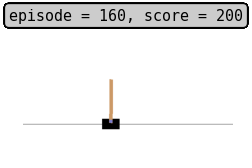

In [7]:
if SAVE_GIF:
    print("Creating gif. This may take a while...")
    save_frames_as_gif()

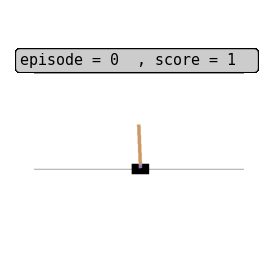

In [8]:
if SAVE_GIF:
    display(Image("animation.gif"))

In [9]:
env.close()  # close Gym